<h1>Imports

In [128]:
# is a good pratice only import what you need in the notebook , ill refactor this later in these notebooks :)

import sys
sys.path.append(r'C:\Users\bield\Documents\projsData\proj-1\utils')

import utils as u
import pandas as pd
from pyspark.sql import (functions as F,
                        DataFrame,
                        Window)
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType,StringType



<h3>Create spark session

In [2]:
spark = u.createSparkSesion()

<h1>Code

In [3]:
df_lol = spark.read.csv("..\..\datasets\League of legend Champions 2024.csv",header=True)

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\bield\AppData\Local\Temp\ipykernel_22824\4210075137.py:1: SyntaxWarning: invalid escape sequence '\.'
  df_lol = spark.read.csv("..\..\datasets\League of legend Champions 2024.csv",header=True)


In [4]:
df_lol.takePandas(10)

,Name,Nick Name,Classes,Release Date,Last Changed,Blue Essence,RP,Difficulty,Role,Range type,Resourse type,Base HP,Base mana
0,Aatrox,The darkin blade,Juggernaut,2013-06-13,V14.14,4800,880,Advanced,Top,Melee,Blood Well,650,0
1,Ahri,The nine-tailed fox,Burst,2011-12-14,V14.18,3150,790,Intermediate,Middle,Ranged,Mana,590,418
2,Akali,The rogue assassin,Assassin,2010-05-11,V14.18,3150,790,Expert,"Top,Middle",Melee,Energy,600,200
3,Akshan,The rogue sentinel,Marksman Assassin,2021-07-22,V14.14,4800,880,Intermediate_Plus,Middle,Ranged,Mana,630,350
4,Alistar,The minotaur,Vanguard,2009-02-21,V14.16,1350,585,Novice,Support,Melee,Mana,685,350
5,Amumu,The sad mummy,Vanguard,2009-06-26,V14.9,450,260,Beginner,"Jungle,Support",Melee,Mana,685,285
6,Anivia,The cryophoenix,Battlemage,2009-07-10,V13.22,3150,790,Intermediate_Plus,Middle,Ranged,Mana,550,495
7,Annie,The dark child,Burst,2009-02-21,V14.4,450,260,Beginner,Middle,Ranged,Mana,560,418
8,Aphelios,The weapon of the faithful,Marksman,2019-12-11,V14.14,4800,880,Expert,Bottom,Ranged,Mana,580,348
9,Ashe,The frost archer,Marksman,2009-02-21,V14.12,450,260,Beginner,"Bottom,Support",Ranged,Mana,640,280


In [5]:
df_lol.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Nick Name: string (nullable = true)
 |-- Classes: string (nullable = true)
 |-- Release Date: string (nullable = true)
 |-- Last Changed: string (nullable = true)
 |-- Blue Essence: string (nullable = true)
 |-- RP: string (nullable = true)
 |-- Difficulty: string (nullable = true)
 |-- Role: string (nullable = true)
 |-- Range type: string (nullable = true)
 |-- Resourse type: string (nullable = true)
 |-- Base HP: string (nullable = true)
 |-- Base mana: string (nullable = true)



In [6]:
for column in df_lol.columns:
    df_lol = df_lol.withColumnRenamed(  column  ,   column.lower()  )

<h1> Roles distribution

Question: Witch roles are more comum between the champs ?<br>
Insight: Share and count for each role.<br>
Benefir: Identify witch role have more champs , and if have any discrepancy.

In [7]:
df_lol.count()

168

In [8]:
roles_distribution = (df_lol.groupBy("classes")
                      .count()
                      .withColumn("share",F.col("count")/df_lol.count())
                      .withColumn("classes",F.when(
                                                    F.col("count")<=1,F.lit("Others")
                                                  ).otherwise(F.col("classes"))
                                  )
                      .groupBy("classes","count","share")
                      .agg(
                          F.sum(F.col("count")).alias("count_"),
                          F.sum(F.col("share")).alias("share_")
                      )
                      .orderBy(F.desc("count_"))
                      .drop("count","share")
                      )

pd_roles_distribution = roles_distribution.toPandas()

In [9]:
roles_distribution.takePandas(1)

,classes,count_,share_
0,Marksman,21,0.125


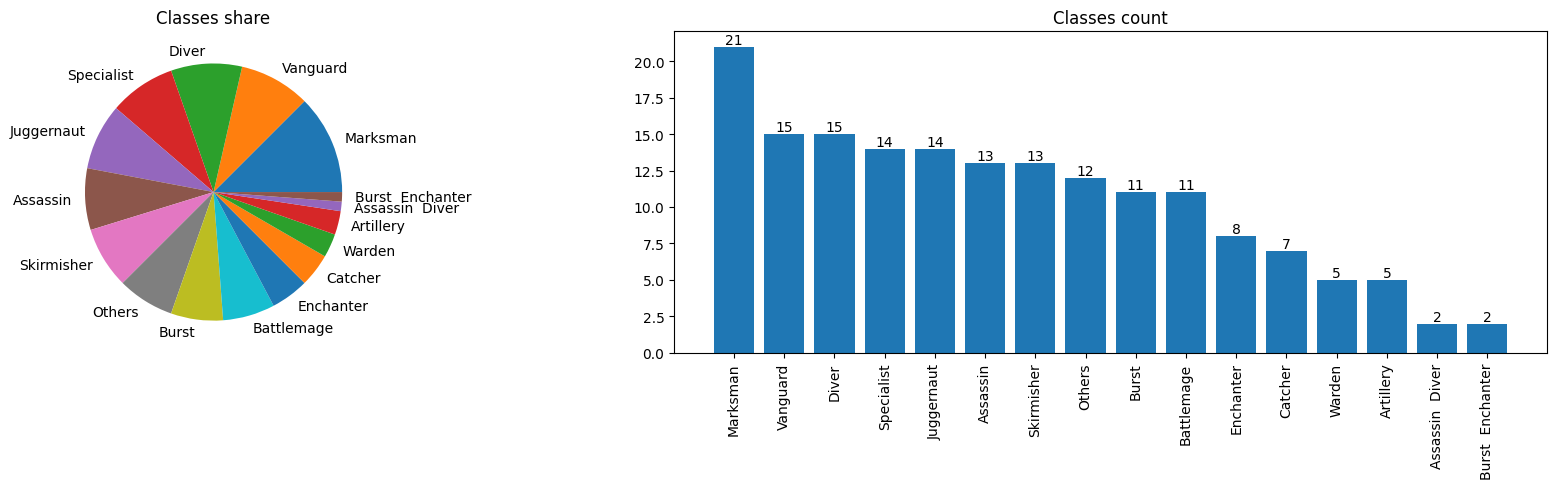

In [10]:
fig, ax1 = plt.subplots(1,2,figsize=(18, 5))

ax1[0].pie(pd_roles_distribution['share_'],labels = pd_roles_distribution['classes'], )
bars = ax1[1].bar(pd_roles_distribution['classes'],pd_roles_distribution['count_'],label="classes count")

for bar in bars:
    yval = bar.get_height(),
    ax1[1].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

    
ax1[0].set_title('Classes share')
ax1[1].set_title('Classes count')



plt.xticks(rotation=90)
plt.tight_layout()


<h1>Cost analysis (Blue Essence e RP)</h1></br>
 Pergunta: Qual é a distribuição dos custos dos campeões em termos de Blue Essence e RP?</br>
 Insight: Comparação dos custos médios e se existe correlação entre Blue Essence e RP.</br>
 Benefício: Identificar possíveis padrões de precificação e campeões que oferecem mais "valor" pelo seu custo.</br>

In [78]:
cost_df  = (df_lol.select("name","blue essence","rp")
                  .withColumn("champs_count_by_blue_essence",F.count("*").over(Window.partitionBy("blue essence")))
                  .withColumn("champs_count_by_rp",F.count("*").over(Window.partitionBy("rp"))))

In [103]:
cost_df_sample = (cost_df.sample(0.30,seed=42)
                  .withColumn("blue essence",cost_df['blue essence'].cast(IntegerType()))
                  .withColumn("rp",cost_df['rp'].cast(IntegerType()))
                  .orderBy(F.desc(F.col("blue essence")),F.desc(F.col("rp"))))

In [104]:
cost_df_sample.printSchema()
# trasnformar o tipo da coluna pois estava dando problema na hora de ordenar o grafico

root
 |-- name: string (nullable = true)
 |-- blue essence: integer (nullable = true)
 |-- rp: integer (nullable = true)
 |-- champs_count_by_blue_essence: long (nullable = false)
 |-- champs_count_by_rp: long (nullable = false)



In [105]:
cost_df_sample.toPandas().sort_values(by="rp",ascending=False)["rp"]
#testando se a ordenacao funciona depois do fix

0     975
1     880
2     880
3     880
4     880
5     880
6     880
7     880
8     880
9     880
10    880
11    880
12    880
13    880
14    880
15    880
16    880
17    880
35    880
19    790
18    790
21    790
22    790
23    790
20    790
25    790
26    790
27    790
28    790
29    790
30    790
31    790
24    790
32    790
33    790
34    790
36    585
37    585
38    585
39    585
40    585
41    585
42    585
43    585
44    585
45    260
46    260
47    260
48    260
Name: rp, dtype: int32

In [106]:
cost_df_sample_pd = cost_df_sample.toPandas()

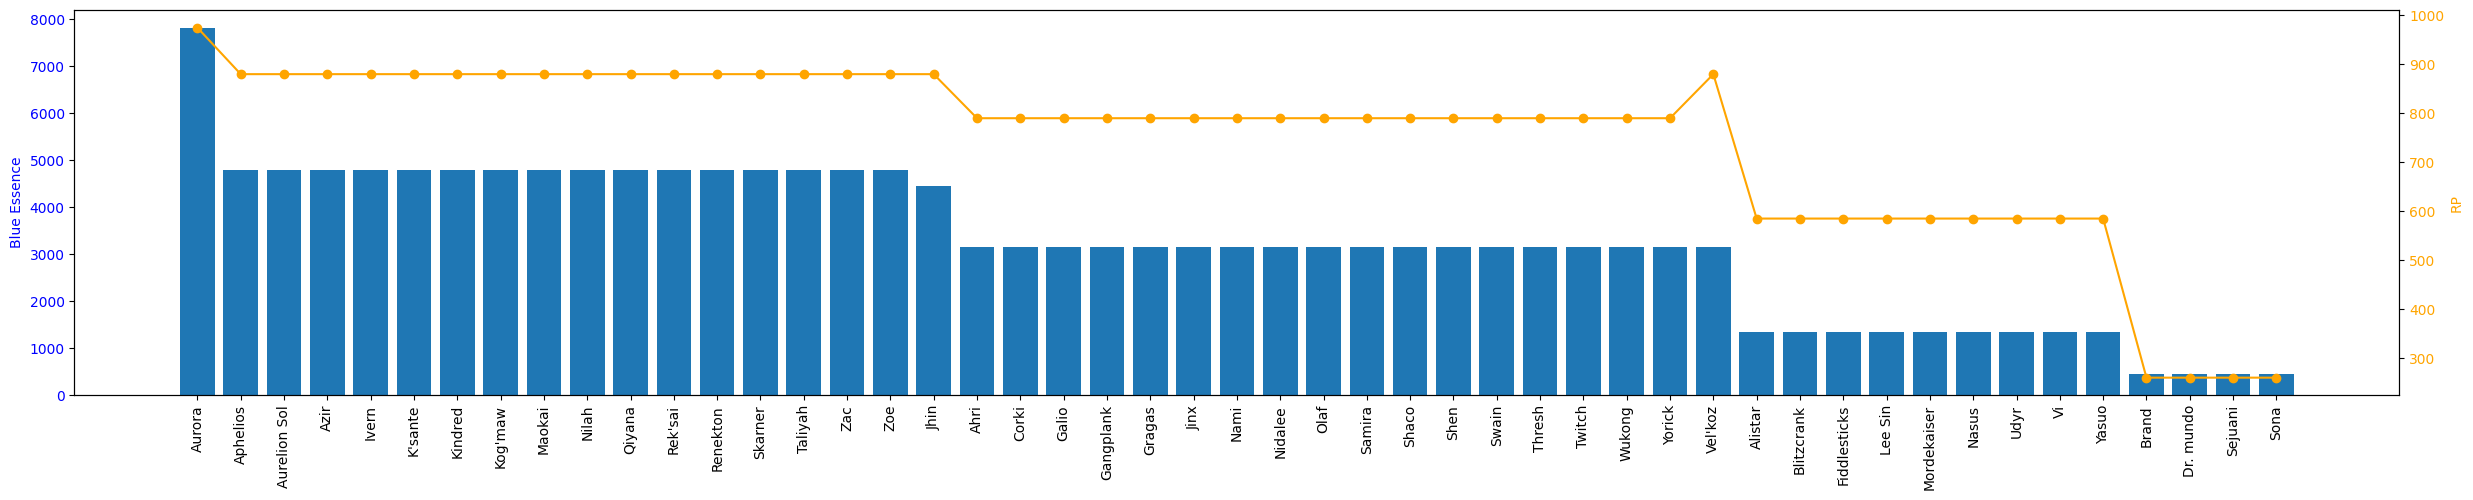

In [107]:
fig , ax1 = plt.subplots(figsize=(30,5))

ax1.set_ylabel('Blue Essence', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.bar(cost_df_sample_pd['name'],cost_df_sample_pd['blue essence'])

ax1.tick_params(axis='x',rotation=90)

ax2 = ax1.twinx()
ax2.set_ylabel("RP",color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.plot(cost_df_sample_pd['name'],cost_df_sample_pd['rp'],color='orange', marker='o')




In [132]:
bp = cost_df_sample.select(F.col("blue essence").cast(StringType()).alias("blue essence"),"champs_count_by_blue_essence").distinct().toPandas().sort_values(by="champs_count_by_blue_essence",ascending=False)
rp = cost_df_sample.select(F.col("rp").cast(StringType()).alias("rp"),"champs_count_by_rp").distinct().toPandas().sort_values(by="champs_count_by_rp",ascending=False)

In [133]:
bp

,blue essence,champs_count_by_blue_essence
4,4800,59
1,3150,47
0,1350,31
3,450,23
2,3141,1
5,4444,1
6,7800,1


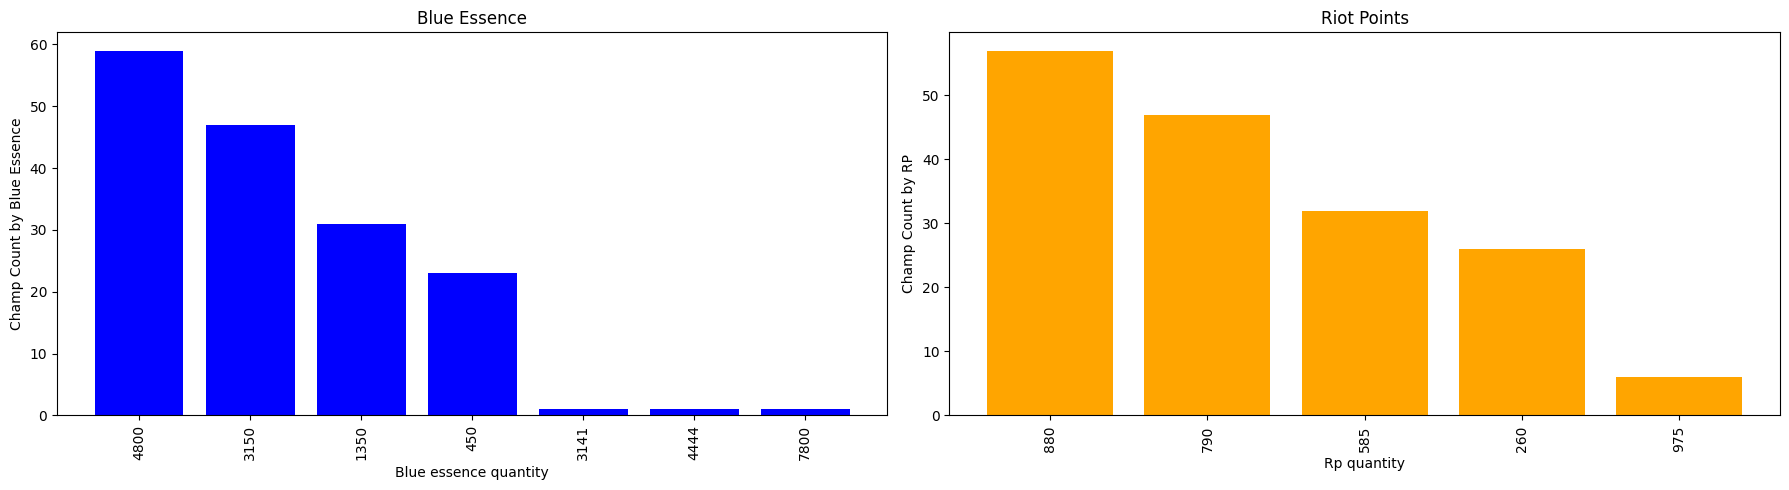

In [139]:

fig, ax1 = plt.subplots(1, 2, figsize=(18, 5))

ax1[0].bar(bp['blue essence'], bp['champs_count_by_blue_essence'], color='b')
ax1[0].set_title('Blue Essence')
ax1[0].set_xlabel('Blue essence quantity')
ax1[0].set_ylabel('Champ Count by Blue Essence')
ax1[0].tick_params(axis='x', rotation=90)

ax1[1].bar(rp['rp'], rp['champs_count_by_rp'], color='orange')
ax1[1].set_title('Riot Points')
ax1[1].set_xlabel('Rp quantity')
ax1[1].set_ylabel('Champ Count by RP')
ax1[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
##acho que ficaria mais legal em pie dps iterar um grafico percentual em pie

 pendidng</br>

 4. Evolução dos Campeões ao Longo do Tempo</br>
 Pergunta: Existe alguma tendência na complexidade ou papel dos campeões ao longo do tempo?</br>
 Insight: Analisar campeões pela data de lançamento (Release Date) para ver se campeões mais recentes são, em média, mais difíceis de jogar ou ocupam papéis diferentes em comparação com campeões mais antigos.</br>
 Benefício: Entender como o design de campeões evoluiu ao longo do tempo.</br>
 5. Análise de Vida e Mana Base</br>
 Pergunta: Campeões com mais vida base tendem a ter menos mana ou algum outro trade-off?</br>
 Insight: Analisar a relação entre a vida base (Base HP) e a mana base (Base Mana).</br>
 Benefício: Explorar padrões de balanceamento no design dos campeões.</br>
 6. Diferença entre Campeões Corpo-a-Corpo e à Distância</br>
 Pergunta: Campeões de combate corpo-a-corpo (melee) tendem a ter mais vida ou menos mana do que campeões de longo alcance (range)?</br>
 Insight: Comparar a vida base, mana base e dificuldade dos campeões de diferentes tipos de alcance (Range type).</br>
 Benefício: Avaliar como o estilo de combate afeta os atributos e a jogabilidade.</br>
 7. Atualizações Recentes</br>
 Pergunta: Campeões que foram modificados recentemente (Last Changed) têm alguma alteração significativa em seus atributos?</br>
 Insight: Comparar campeões recentemente alterados com os não alterados, focando em mudanças em dificuldade, vida base, mana base e outros atributos.</br>
 Benefício: Ver como as atualizações estão impactando o balanceamento do jogo.</br>
 8. Campeões com Pseudônimos ("Nick Name")</br>
 Pergunta: Existe alguma relação entre os campeões que possuem "Nick Name" e suas características (dificuldade, papel, tipo de alcance, etc.)?</br>
 Insight: Verificar se campeões com pseudônimos têm características únicas ou se seguem algum padrão.</br>
 Benefício: Analisar como o uso de pseudônimos pode influenciar a percepção dos campeões pelos jogadores.